# Spiking Neural Networks, Part II: Networks and Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time
import math as math

Note that all models described below can be solved with simple forward-Euler numerical integration.

## Simulating a spiking layer

In this section, we will create a random spike-train and stimulate an output neuron via this spike-train.

#### Creating random background spiking

The code below uses a random number generator to produce a spike train.

In [2]:
def create_random_spikes(nb_neurons, timestep, total_time, firing_rate, seed=42):
    """Generate a random spike train

    Parameters
    ----------
      nb_neurons -- the number of neurons to create spike trains for
      timestep -- the timestepping magnitude of your solver (ms)
      total_time -- the total time of simulation (ms)
      firing_rate -- the average number of spikes (per millisecond) to produce
      seed -- a random seed for reproducibility (default=42)

    Returns
    -------
      spikes: A binary matrix of size "nb_neurons x (total_time / timestep)"
              The average number of 1s per row (per neuron) is total_time*firing_rate
    """
    np.random.seed(42) # Initialising random generator for repeatability
    nb_timesteps = int(total_time / timestep)
    spikes_per_timestep = firing_rate*timestep
    random_spikes = np.random.rand(nb_neurons, nb_timesteps)
    random_spikes = random_spikes < spikes_per_timestep
    return random_spikes

In [3]:
# Parameters of the random generation
timestep = 0.1             # ms
total_time = 0.1*1000      # ms
firing_rate = 0.1  # spikes per millisecond
nb_inputs = 2000

random_spikes = create_random_spikes(nb_inputs, timestep, total_time, firing_rate)

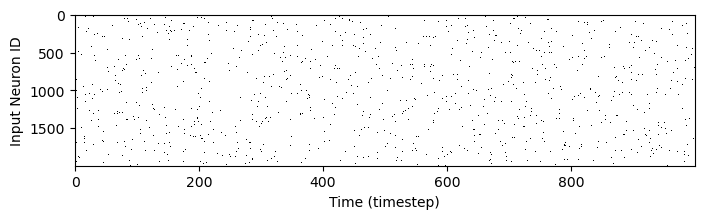

In [4]:
plt.figure(figsize=(8,2), dpi=100)
plt.imshow(random_spikes, aspect='auto', interpolation='nearest', cmap='gray_r');
plt.ylabel("Input Neuron ID")
plt.xlabel("Time (timestep)");

In [5]:
random_spikes.shape # nb_inputs x 1000
print(random_spikes[:, 0])

[False False False ... False False False]


### TASK 1: Simulating a single LIF neuron with input spiking activity

Below I provide a skeleton class for a layer of leaky integrate and fire neurons.
We desire the dynamics to be those of a leaky-integrate and fire neuron.
The membrane voltages will evolve such that:

$$
\tau_m \frac{dv_i(t)}{dt} = (v_{\text{rest}} - v_i(t))
$$

We shall also simulate the inputs as so-called 'voltage-based' synapses.
Lets assume that there exists a weight, $w_{ij}$, from input neuron $j$ to output neuron $i$.
We shall simulate inputs such that:
$$
v_i \gets v_i + w_{ij} \text{ when neuron $j$ spikes.}
$$

If the output neuron voltage ever reaches a threshold, we shall record a spike and reset the voltage.
This can be written:

$$
    v_i(t)= 
\begin{cases}
    v_{\text{reset}} ,& \text{(and record a spike) if } v_i(t) > v_{\text{thresh}}\\
    v_i(t),              & \text{otherwise}
\end{cases}
$$

You shall now build this simple spiking system.

    Speed: 2.516 -> 1.561 -> 0.03 seconds
    
```:::python
# loop through input spikes
for i in range(0, len(input_spikes)):
    # if a input spikes in the current time step update membrane voltage V <- V + W
    if input_spikes[i] == True:
        self.membrane_voltages[o] += self.weight_matrix[o, i]

        # if the voltage > threshold : spike and reset
        if self.membrane_voltages[o] > v_thresh:
            self.membrane_voltages[o] = v_rest
            spikes[o] += 1
           
```

In [6]:
# We define some parameters here, voltages are unitless for now
params = {
    'v_rest': 0.0,
    'v_thresh': 500.0,
    'tauM': 10.0,     #ms
    'timestep': timestep   #ms
}

In [28]:
class LIF_layer():
    """A class to store internal variables of our LIF neurons and to spit out spikes
    """
    def __init__(self, nb_inputs, nb_outputs, parameters, seed=42):
        """Initialises internal variables (weight matrix and membrane voltages)

            Parameters
            ----------
              nb_inputs: number of input neurons
              nb_outputs: number of LIF neurons to simulate (receiving inputs)
              parameters: a dictionary of parameters needed to update the internal state
        """
        # State variables for this class
        self.parameters = parameters # A dictionary of parameters
        self.membrane_voltages = np.zeros(nb_outputs)
        self.weight_matrix = np.random.rand(nb_outputs, nb_inputs)
        
        print("nb_inputs", nb_inputs, "nb_outputs", nb_outputs)
        print("m_v", self.membrane_voltages)
        print("w ", self.weight_matrix, self.weight_matrix.shape)

    def update_states(self, input_spikes: list):
        """
        A method which updates the internal state of the network.
        It steps the network dynamics forward by one timestep given some inputs.

            Parameters
            ----------
              input spikes: A binary vector (of length nb_inputs) indicating whether a neuron spiked or not

            Returns
            -------
              spikes: A binary vector (of length nb_outputs) indicating 
                        which internal neurons spiked in this timestep
                        
            
            v_i <- v_i + w_ij when j spikes
        """
        # WRITE CODE HERE TO UPDATE THE MEMBRANE_VOLTAGES FOR 1 TIMESTEP
        # ALSO COMPUTE A BINARY VECTOR OF SPIKES (0 no spike, 1 spike)
        # RETURN THE SPIKE VECTOR

        # You will need to use the parameters:
        # self.parameters['timestep'], self.parameters['tauM'], 
        # self.parameters['v_rest'], self.parameters['v_thresh']
        
        timestep = self.parameters['timestep']
        tauM     = self.parameters['tauM']
        v_rest   = self.parameters['v_rest']
        v_thresh = self.parameters['v_thresh']

        spikes = np.zeros(len(self.membrane_voltages))

        # evolve the membrane voltage using the normal LIF dynamics
        dv_t = ((timestep * (v_rest - self.membrane_voltages[:])) / tauM )
        self.membrane_voltages[:] += dv_t

        # multiply inputs by the weights 
        inputs = self.weight_matrix[:,:] * input_spikes

        # sum the inputs to get the total amount of input activation
        sum_inputs = np.sum(inputs) + self.membrane_voltages[:]

        # the mod of the summed inputs and the threshold gives us the final voltage of the membrane
        self.membrane_voltages[:] = sum_inputs % v_thresh
        
        # devision of summed inputs and threshold gives us the number of spikes
        spikes[:] = math.floor(sum_inputs / v_thresh)            
        
        return spikes

Code has been written below to create, run and plot the model.

In [29]:
model = LIF_layer(nb_inputs, 1, params)

nb_inputs 2000 nb_outputs 1
m_v [0.]
w  [[0.32648356 0.46758977 0.37060591 ... 0.38789883 0.41213337 0.85178683]] (1, 2000)


In [30]:
out_spikes = []
out_mem = []

start = time.time()
# Run the model state update for each timestep of our inputs
# Store the spikes of the output neurons and a copy of the membrane voltages
for ts in range(random_spikes.shape[1]):
    out_mem.append(np.copy(model.membrane_voltages))
    output_spikes = model.update_states(random_spikes[:, ts])
    out_spikes.append(output_spikes)
    
print("time elapsed: ", time.time() - start)

# 14 spikes

time elapsed:  0.05488085746765137


The plotting code below should show the evolution of the membrane voltage and the sike train of the output neuron

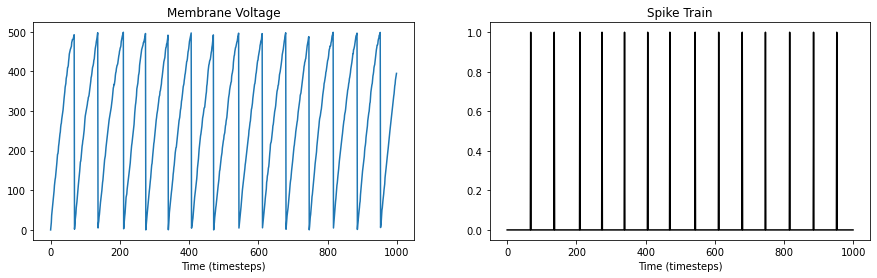

In [34]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1);
plt.plot(np.asarray(out_mem));
plt.title("Membrane Voltage");
plt.xlabel("Time (timesteps)");
plt.subplot(1,2,2);
plt.plot(np.asarray(out_spikes), color='k');
plt.title("Spike Train");
plt.xlabel("Time (timesteps)");

## **Using STDP to find repeating spiking patterns**

We shall now embed a repeating pattern within some random spikes. Your task will then be to implement Spike-Timing Dependent Plasticity (STDP) -- an unsupervised method for learning. We expect that after training, a single neuron will learn our repeating pattern and ignore the background (random) spikes.

In [35]:
# Creating a longer set of background random spikes
total_time = 10.0*1000      # ms
input_random_spikes = create_random_spikes(nb_inputs, timestep, total_time, firing_rate)

# Creating a short random pattern (20ms), with a different seed
pattern_spikes = create_random_spikes(nb_inputs, timestep, 20.0, firing_rate, seed=1)

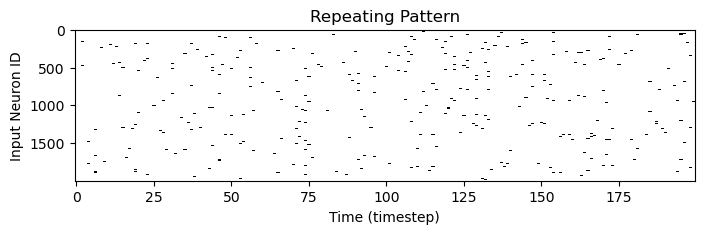

In [36]:
plt.figure(figsize=(8,2), dpi=100)
plt.imshow(pattern_spikes, aspect='auto', interpolation='nearest', cmap='gray_r');
plt.ylabel("Input Neuron ID")
plt.xlabel("Time (timestep)")
plt.title("Repeating Pattern");

### Placing the repeating pattern at random places in the background spiking

In [37]:
np.random.seed(43)
num_insertions = int(10*(total_time / 1000.0)) # Inserting ten times per 1s of simulation
insertions = np.random.randint(low=0, high=input_random_spikes.shape[1], size=num_insertions)
insertions = np.sort(insertions)

for insert in insertions:
    input_random_spikes[:, insert:(insert + pattern_spikes.shape[1])] = pattern_spikes

### TASK 2: Creating a LIF layer with STDP modifying the weights

Below I define a class which has an internal state not only for the LIF neuron variables but also for variables related to STDP.
As before, we shall simulate the dynamics of a LIF neuron (please see TASK 1 for details of the dynamics).
Here we extend these dynamics to include Spike-Timing Dependent Plasticity (STDP).

Your task is to include within the state update of our model both the dynamics of the neuron membrane voltage and also dynamics of some internal trace variables that will be used to enact STDP.

In particular, STDP should operate such that there is a change in the weight from neuron indexed $j$ to neuron indexed $i$, $\Delta w_{ij}$, based upon the time differences between all pairs of spikes in a network.
This weight change is defined:

$$
    \Delta w_{ij} = 
\begin{cases}
    A_+ e^{\frac{\Delta t}{\tau_+}} ,& \text{for all pairs of spikes where } \Delta t \text{ is negative}\\
    -A_- e^{\frac{-\Delta t}{\tau_-}},& \text{for all other pairs of spikes.}
\end{cases}
$$
where $\Delta t$ is the time difference between the output ($i$th) and input spike ($j$th),  $\Delta t = t_{\text{spike}}^j - t_{\text{spike}}^i$.

Note, as mentioned in the lectures (See Spiking Neural Networks II, slides 30-35) it is possible to carry out these pair-wise weight updates using synaptic traces instead of storing all of the spike times.

In [38]:
stdp_params = {
    'v_rest': 0.0,
    'v_thresh': 500.0,
    'tauM': 10.0,
    'timestep': 0.1,
    'tau_plus': 10.0,
    'tau_minus': 10.0,
    'A_plus': 0.005,
    'A_minus': 1.1*0.005
}

In [239]:
class LIF_STDP_layer():
    """A class storing internal variables of our LIF neurons and STDP rule
    """
    def __init__(self, nb_inputs, nb_outputs, parameters, seed=42):
        """Initialises internal variables (weight matrix and membrane voltages)

            Parameters
            ----------
              nb_inputs: number of input neurons
              nb_outputs: number of LIF neurons to simulate (receiving inputs)
              parameters: a dictionary of parameters needed to update the internal state
        """
        print("nb_inputs ", nb_inputs)
        print("nb_outputs", nb_outputs)
        # State variables for this class
        self.parameters = parameters
        self.membrane_voltages = np.zeros(nb_outputs) # (1,)
        np.random.seed(seed)
        self.weight_matrix = 0.5*np.ones((nb_outputs, nb_inputs)) # (1, 2000)

        # Traces for STDP
        self.stdp_input_traces = np.zeros(nb_inputs)   # (2000, )
        self.stdp_output_traces = np.zeros(nb_outputs) # (1, )

    def update_states(self, input_spikes):
        """A method which updates the internal state of the network.
            It steps the network dynamics forward by one timestep given some inputs.

            Parameters
            ----------
              input spikes: A binary vector (of length nb_inputs) indicating
              input_spikes -- shape -- (2000, )

            Returns
            -------
              spikes: A binary vector (of length nb_outputs) indicating 
                        which internal neurons spiked in this timestep
        """
        # WRITE CODE HERE TO UPDATE THE MEMBRANE_VOLTAGES, AND STDP TRACES FOR 1 TIMESTEP
        # THEREAFTER, IT SHOULD UPDATE THE WEIGHT MATRIX BASED UPON THE SPIKES AND TRACES
        # AS BEFORE IT SHOULD RETURN THE SPIKE VECTOR
        
        spikes = np.zeros(len(self.membrane_voltages))

        # For membrane updating, you will need to use the parameters:
        # self.parameters['timestep'], self.parameters['tauM'], 
        # self.parameters['v_rest'], self.parameters['v_thresh']
        timestep = self.parameters['timestep']
        tauM     = self.parameters['tauM']
        v_rest   = self.parameters['v_rest']
        v_thresh = self.parameters['v_thresh']
        
        # For STDP, you will need to use the parameters:
        # self.parameters['A_plus'], self.parameters['A_minus'], 
        # self.parameters['tau_plus'], self.parameters['tau_minus'], 
        a_plus    = self.parameters['A_plus']
        a_minus   = self.parameters['A_minus']
        tau_plus  = self.parameters['tau_plus']
        tau_minus = self.parameters['tau_minus']
        timestep  = self.parameters['timestep'] 
        
        # LIF dynamics 
        self.membrane_voltages[:] += ((timestep * (v_rest - self.membrane_voltages[:])) / tauM )
        
        # same code as previously for getting the membrane voltage
        inputs = self.weight_matrix[:, :] * input_spikes        # Get the weight of each input spike (0 if no spike)
        sum_inputs = np.sum(inputs) + self.membrane_voltages[:] # Sum the inputs with the current membrane voltage
        self.membrane_voltages[:] = sum_inputs % v_thresh # voltage is the modulo of the summed inputs and threshold
        spikes[:] = math.floor(sum_inputs / v_thresh)           # nr. of spikes is summed inputs divided by threshold
           
        # Add 1 everytime input/output spikes
        if spikes[:] > 0:
            self.stdp_output_traces[:] += 1
        self.stdp_input_traces[:] += input_spikes # <==> np.sign(inputs.reshape((2000,)))
        

        # apply the exponential decay to the two traces
#         self.stdp_input_traces += timestep * -1 * self.stdp_input_traces/tau_plus
#         self.stdp_output_traces += timestep * -1 * self.stdp_output_traces/tau_minus
        self.stdp_input_traces = self.stdp_input_traces * (np.exp(-timestep/tau_plus))
        self.stdp_input_traces = input_spikes + self.stdp_input_traces
        
        self.stdp_output_traces = self.stdp_output_traces * (np.exp(-timestep/tau_minus))
           
        # update the weight matrix 
#         if spikes[:] > 0: 
#             # if LIF spikes -> update the incoming spiking signal weights
#             self.weight_matrix[:,:] += self.stdp_input_traces * -a_minus * np.exp(-timestep/tau_minus)        
        
# #         self.weight_matrix[:,:] += ((abs(input_spikes-1))) * -a_minus * np.exp(-1/tau_minus)
#         self.weight_matrix[:, :] += input_spikes * self.stdp_output_traces * (a_plus * np.exp(timestep/tau_plus))
        
        dW = -a_minus * self.stdp_output_traces
        self.weight_matrix[:,input_spikes] += dW
    
        if spikes[:] > 0:
            self.stdp_output_traces += 1
            dW = a_plus * self.stdp_input_traces
            self.weight_matrix += dW
            
        

        return spikes

As above, code is provided below to create, run and then plot the outputs of your model.

In [240]:
stdp_model = LIF_STDP_layer(nb_inputs, 1, stdp_params)

print("input_random_spikes:", input_random_spikes.shape)

nb_inputs  2000
nb_outputs 1
input_random_spikes: (2000, 100000)


In [241]:
out_spikes = []
input_traces = []
out_mem = []

# Run the model state update for each timestep of our input
# Store:   - the spikes of the output neurons
#          - the membrane voltages
#          - the input stdp trace (to check for sanity)
start = time.time()

for ts in range(input_random_spikes.shape[1]):
    out_mem.append(np.copy(stdp_model.membrane_voltages))
    output_spikes = stdp_model.update_states(input_random_spikes[:, ts])
    input_traces.append(np.copy(stdp_model.stdp_input_traces))
    out_spikes.append(output_spikes)
    
print("time elapsed: ", time.time() - start)

time elapsed:  34.74120831489563


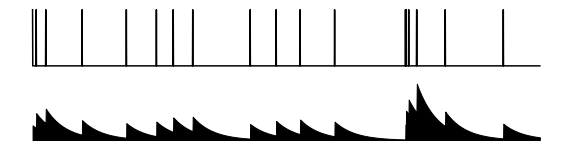

In [242]:
plot_timesteps = 2500

plt.figure(figsize=(10,2.5))
ax = plt.subplot(2,1,1);
ax.plot(input_random_spikes[6,:plot_timesteps], color='k');
plt.axis('off')
ax = plt.subplot(2,1,2);
ax.fill_between(np.arange(plot_timesteps), 0, np.asarray(input_traces)[:plot_timesteps,6], color='k')
plt.axis('off');

(0.0, 10000.0)

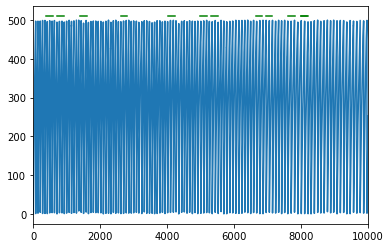

In [243]:
# Plotting where the repeating patterns are
for insert in insertions:
    plt.plot([insert, insert+pattern_spikes.shape[1]], [510, 510], color='g')
# Plotting network activity
plt.plot(np.asarray(out_mem));
plt.xlim([0, 10000])

(90000.0, 100000.0)

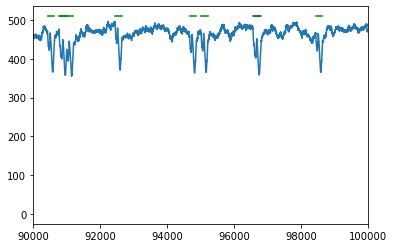

In [244]:
# Plotting where the repeating patterns are
for insert in insertions:
    plt.plot([insert, insert+pattern_spikes.shape[1]], [510, 510], color='g')
# Plotting network activity
plt.plot(np.asarray(out_mem));
plt.xlim([90000, 100000])

Text(0.5, 0, 'Synaptic Weights')

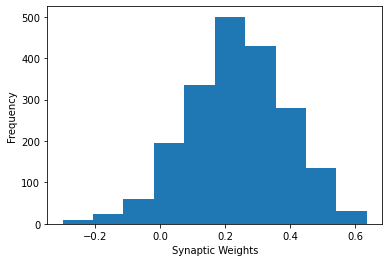

In [245]:
plt.hist(stdp_model.weight_matrix.flatten());
plt.ylabel("Frequency")
plt.xlabel("Synaptic Weights")